In [4]:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image, ImageChops
from scipy.signal import  correlate2d
import pywt

In [51]:
X_full= mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 1) #downsizing image
height,width = X.shape #getting height and width of image
print([height,width])

[256, 256]


In [52]:
def dct2 ( x ) :
  return spfft.dct(spfft.dct( x.T , norm = "ortho" , axis = 0).T , norm = "ortho" , axis = 0 )
def idct2 ( x ) :
  return spfft.idct( spfft.idct( x.T , norm = "ortho" , axis = 0 ).T , norm = "ortho" , axis = 0)

In [53]:
Y = dct2(X)
y = Y[:45,:45].flatten()

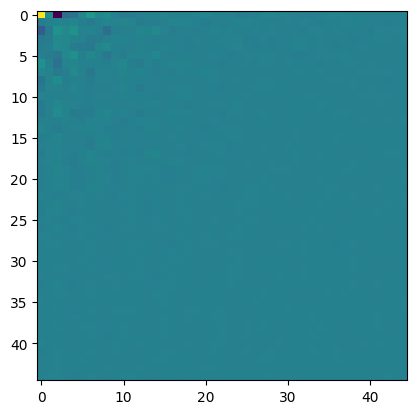

In [7]:
plt.imshow(Y[:45, :45])

In [8]:
A = np.zeros((900,900))
for i in range(900):
  index = np.random.randint(0, 900)
  A[i][index] = 1



In [54]:
A = np.random.randn(45**2,45**2)

In [ ]:
A = np.random.randint(0,2,(45**2,45**2))

In [55]:
b = A@y

In [56]:
ysparse = cvx.Variable(45**2)
obj = cvx.Minimize(cvx.norm(ysparse, 1))
constraints = [cvx.norm(A@ysparse - b,2) <= 1e-12]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [12]:
y_corner = ysparse.value
y_corner = y_corner.reshape((45,45))

image = np.zeros((height, width))
image[:45,:45] = y_corner
np.count_nonzero(image)

2025

63936 there are that many zeros so the solution is very sparse and 2025 non-sparse coefficients. This works out to be only about 3 percent of the initial data.

In [57]:
image = idct2(image)

In [60]:
normalized_result = image/255
normalized_original = X/255
difference = normalized_original - normalized_result
np.sum(abs(difference))


15575.535167468915

In [8]:
def mse(image1, image2):
    squared_diff = (image1 - image2) ** 2
    mse = squared_diff.mean()
    return mse
def mad(image1, image2):
  diff = image1 - image2
  return np.mean(abs(diff))



In [64]:
print(mse(X, image))
print(mse(normalized_original,normalized_result ))
print(mad(X, image))

5935.298726428803
0.09127718149063901
60.604270442269495


In [65]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image

# Scipy doesn't have a function for taking the discrete cosine transform on 2D signals
# so we are constructing our own.
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image
height,width = X.shape #getting height and width of image

# Extract small sample of signal
k = round(width * height * 0.9) # 90% sample
ri = np.random.choice(width * height, k, replace=False) # random sample of indices
b = X.T.flat[ri]
b = np.expand_dims(b, axis=1)

# Create dct matrix operator using kron (memory errors for large height*width)
A = np.kron(
    spfft.idct(np.identity(width), norm='ortho', axis=0),
    spfft.idct(np.identity(height), norm='ortho', axis=0)
    )
A = A[ri,:]

# Do L1 optimization
vx = cvx.Variable(width * height)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b.flatten()]  # Flatten b to make it 1D
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

Xat = Xat2.reshape(width, height).T # stack columns
Xa = idct2(Xat) #reconstructed image

                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Apr 08 02:49:00 AM: Your problem has 1444 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 08 02:49:00 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 02:49:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 02:49:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 02:49:00 AM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 08 02:49:00 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Apr 08 02:49:01 AM: Applying reduction ECOS
(CVXPY) Apr 08 02:49:01 AM: Finished problem compilation (took 1.058e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 08 02:49:01 AM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Apr 08 02:49:37 AM: Problem status: optimal
(CVXPY) Apr 08 02:49:37 AM: Optimal value: 3.952e+04
(CVXPY) Apr 08 02:49:37 AM: Compilation took 1.058e+00 seconds
(CVXPY) Apr 08 02:49:37 AM: Solver (including time spent in interface) took 3.556e+01 seconds


In [66]:
norm_orig = X/255
norm_result = Xa/255
print(mse(norm_orig, norm_result))
print(mse(X,Xa))
print(mad(X,Xa))

0.001659421089322767
107.90385633321291
2.4199891692732844


In [67]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image

X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image
height,width = X.shape #getting height and width of image

Y = np.fft.fft2(X) #take fourier transform
width, height = Y.shape
y = Y.flatten()
Yz = Y.copy()
Yz[np.abs(Yz) < 1000] = 0. #filter out values below a certain threshold
yz = Yz.flatten()
dim = yz.size

square_size = 2
yul = Yz[:square_size, :square_size]
yur = Yz[:square_size, -square_size:]
yll = Yz[-square_size:, :square_size]
ylr = Yz[-square_size:, -square_size:]

corners = np.block([[yul, yur],
              [yll, ylr]])

corners_flat = corners.flatten()
stacked_corners = np.tile(corners_flat, 4)
stacked_corners = stacked_corners[:dim]

num_rows_corners = stacked_corners.shape[0]
size_of_A = (dim//2)*dim

sampled_indices = np.random.randint(0, num_rows_corners, size=size_of_A)
# Create the new matrix by sampling rows from corners using the generated indices
A = stacked_corners[sampled_indices]

A = A.reshape(dim//2,dim)
yz = yz.reshape((-1, 1))

b = A@yz
ysparsereal = cvx.Variable((dim,1))

obj = cvx.Minimize(cvx.norm(ysparsereal, 1))
constraints = [cvx.norm(A@ysparsereal - b.real,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

ysparseimag = cvx.Variable((dim,1))

obj = cvx.Minimize(cvx.norm(ysparseimag, 1))
constraints = [cvx.norm(A@ysparseimag - b.imag,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

ysparse = ysparsereal.value + ysparseimag.value*1j
Ysparse = ysparse.reshape((width,height))
Xhat = np.fft.ifft2(Ysparse).real

In [68]:
norm_orig = X/255
norm_result = Xhat/255
print(mse(norm_orig, norm_result))
print(mse(X,Xhat))
print(mad(X, Xhat))

67.74245100876927
4404952.876845221
1673.8690750852777


In [69]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image

X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 1) #downsizing image
height,width = X.shape #getting height and width of image

Y = np.fft.fft2(X)
width, height = Y.shape

n = 20
yul = Y[:n, :n]
yur = Y[:n, -n:]
yll = Y[-n:, :n]
ylr = Y[-n:, -n:]

Z = np.block([[yul, yur],
              [yll, ylr]])

z = Z.flatten()
z = z.reshape((-1, 1))
A = np.random.randint(0,2,size=((4*n**2),4*n**2))
b = A@z

error_threshold = 1e-8

w_real = cvx.Variable((4*n**2,1))

obj = cvx.Minimize(cvx.norm(w_real, 1))
constraints = [cvx.norm(A@w_real - b.real,2) <= error_threshold]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

w_image = cvx.Variable((4*n**2,1))

obj = cvx.Minimize(cvx.norm(w_image, 1))
constraints = [cvx.norm(A@w_image - b.imag,2) <= error_threshold]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

w_sparse = w_real.value + w_image.value*1j

W = w_sparse.reshape((2*n,2*n))

Y_hat = np.zeros(width*height)
Y_hat = Y_hat.reshape((width,height))

Y_hat[:n, :n] = W[:n, :n] #upper left
Y_hat[:n, -n:] = W[:n, -n:] #upper right
Y_hat[-n:, :n] = W[-n:, :n] #lower left
Y_hat[-n:, -n:] = W[-n:, -n:] #lower right

X_hat = np.fft.ifft2(Y_hat).real

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
<ipython-input-69-63bd1e7b7fdf>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[:n, :n] = W[:n, :n] #upper left
<ipython-input-69-63bd1e7b7fdf>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[:n, -n:] = W[:n, -n:] #upper right
<ipython-input-69-63bd1e7b7fdf>:57: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[-n:, :n] = W[-n:, :n] #lower left
<ipython-input-69-63bd1e7b7fdf>:58: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[-n:, -n:] = W[-n:, -n:] #lower right


In [71]:
norm_orig = X/255
norm_result = X_hat/255
print(mse(norm_orig, norm_result))
print(mse(X,X_hat))
print(mad(X, X_hat))

0.01437301011472419
934.6049827099405
20.056233541327572


In [5]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image
height,width = X.shape #getting height and width of image

Y = pywt.dwt2(X, 'db1')
cA, (cH, cV, cD) = Y

Y = np.block([
    [cA,cH],
    [cV,cD]
])
width, height = Y.shape

y = np.array(Y)
y = Y.flatten()
dim = y.size

yul = Y[:10, :10]
yur = Y[:10, -10:]
yll = Y[-10:, :10]
ylr = Y[-10:, -10:]
corners = np.block([[yul, yur],
              [yll, ylr]])


corners_flat = corners.flatten()

stacked_corners = np.tile(corners_flat, 4)
stacked_corners = stacked_corners[:dim]

num_rows_corners = stacked_corners.shape[0]
size_of_A = (dim//2)*dim

sampled_indices = np.random.randint(0, num_rows_corners, size=size_of_A)

# Create the new matrix by sampling rows from corners using the generated indices
A = stacked_corners[sampled_indices]
A = A.reshape((dim//2),dim)

b = A@y

ysparsereal = cvx.Variable(dim)
obj = cvx.Minimize(cvx.norm(ysparsereal, 1))
constraints = [cvx.norm(A@ysparsereal - b.real,2) <= 1e-12]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

ysparseimag = cvx.Variable(dim)
obj = cvx.Minimize(cvx.norm(ysparseimag, 1))
constraints = [cvx.norm(A@ysparseimag - b.imag,2) <= 1e-12]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

ysparse = ysparsereal.value + ysparseimag.value*1j
Ysparse = ysparse.reshape((width,height))

LL = Ysparse[:(width//2), :(height//2)]
HL = Ysparse[:(width//2), -(height//2):]
LH = Ysparse[-(width//2):, :(height//2)]
HH = Ysparse[-(width//2):, -(height//2):]

coeffs = (LL, (HL, LH, HH))
Xhat = pywt.idwt2(coeffs, 'db1').real

In [9]:
norm_orig = X/255
norm_result = Xhat/255
print(mse(norm_orig, norm_result))
print(mse(X,Xhat))
print(mad(X, Xhat))

0.008018356843727354
521.3936537633712
16.327162911645978
